In [1]:
import fitsio
import numpy as np
import proplot as pplt

## Plot all CCDs

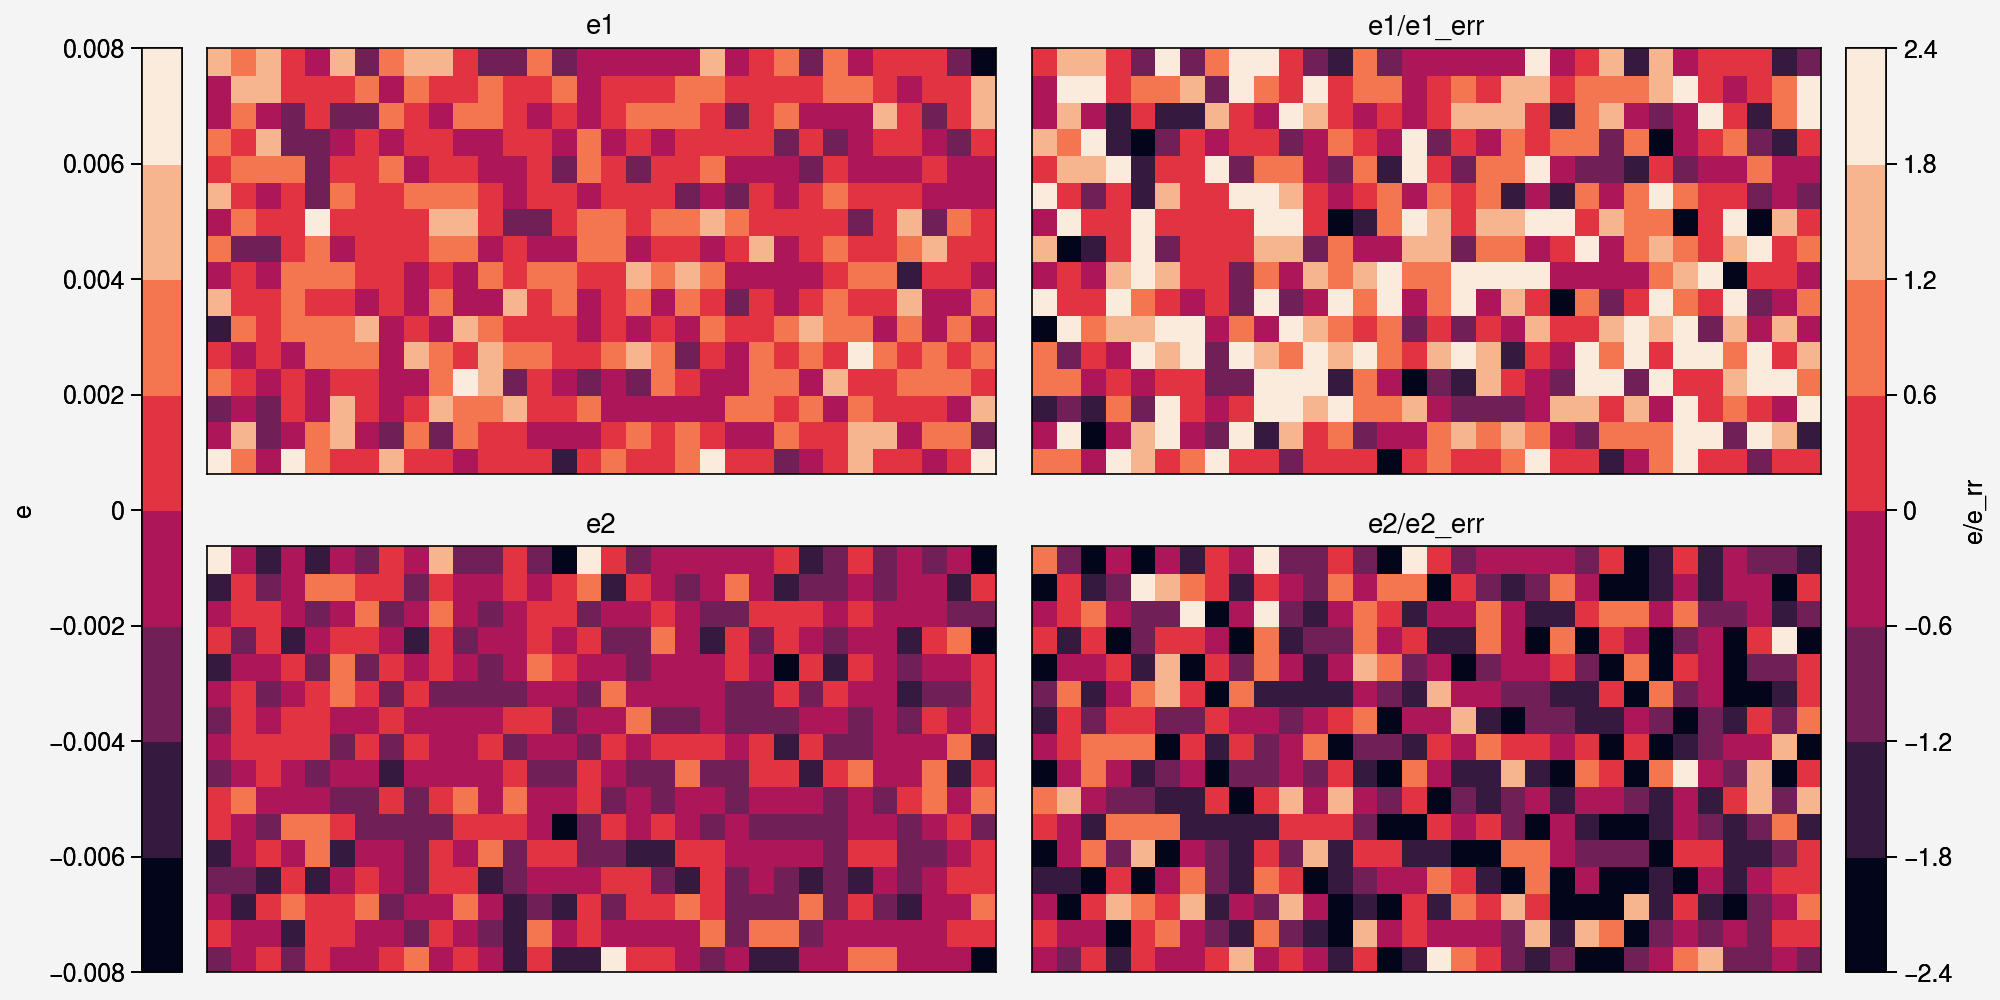

In [2]:
fn = "cte_data_all_ccd.fits"
e1 = fitsio.read(fn, ext="e1")
e1_err = fitsio.read(fn, ext="e1_err")
e2 = fitsio.read(fn, ext="e2")
e2_err = fitsio.read(fn, ext="e2_err")


fig, axs = pplt.subplots(nrows=2, ncols=2, share=0, figsize=(10, 5))

vmax = np.nanmax([np.abs(e1[1:-1, 1:-1]), np.abs(e2[1:-1, 1:-1])])
vmin = -vmax

a = axs[0, 0].pcolormesh(e1.T, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0, 0].grid(False)
axs[0, 0].xaxis.set_visible(False)
axs[0, 0].yaxis.set_visible(False)
axs[0, 0].set_title("e1")

axs[1, 0].pcolormesh(e2.T, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1, 0].grid(False)
axs[1, 0].xaxis.set_visible(False)
axs[1, 0].yaxis.set_visible(False)
axs[1, 0].set_title("e2")

fig.colorbar(a, space=1, loc="l", label="e")

vmin = -3
vmax = -vmin
a = axs[0, 1].pcolormesh(e1.T/e1_err.T, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0, 1].grid(False)
axs[0, 1].xaxis.set_visible(False)
axs[0, 1].yaxis.set_visible(False)
axs[0, 1].set_title("e1/e1_err")

axs[1, 1].pcolormesh(e2.T/e2_err.T, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1, 1].grid(False)
axs[1, 1].xaxis.set_visible(False)
axs[1, 1].yaxis.set_visible(False)
axs[1, 1].set_title("e2/e2_err")

fig.colorbar(a, space=1, loc="r", label="e/e_rr")

## Rows

(-0.0025890751203846815, 0.0025890751203846815)

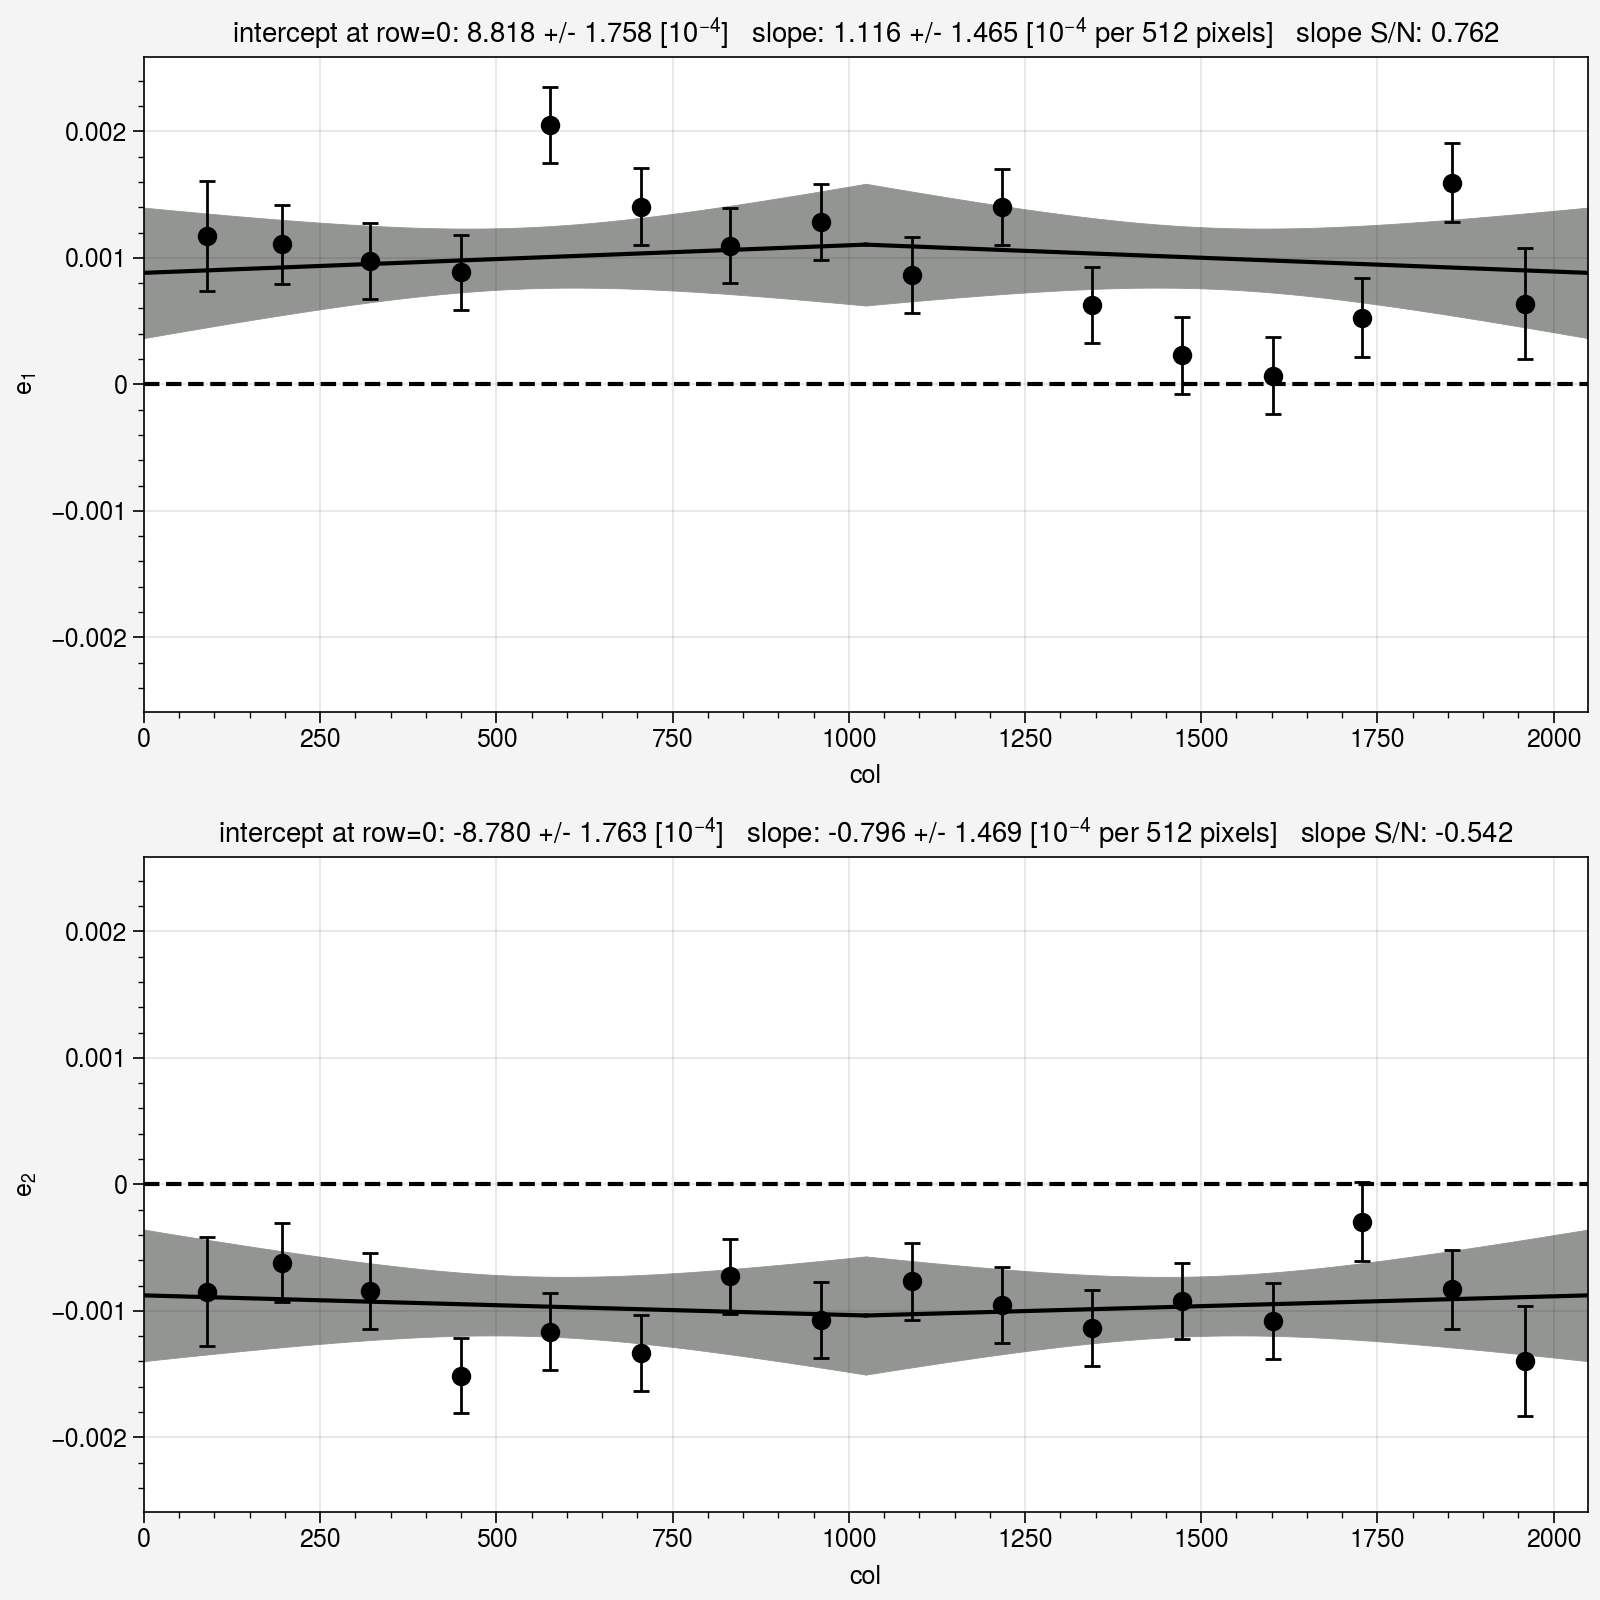

In [3]:
from scipy.optimize import curve_fit

e1s = fitsio.read("cte_data_all_col.fits", ext="e1")
e1s_err = fitsio.read("cte_data_all_col.fits", ext="e1_err")
e2s = fitsio.read("cte_data_all_col.fits", ext="e2")
e2s_err = fitsio.read("cte_data_all_col.fits", ext="e2_err")
cols = fitsio.read("cte_data_all_col.fits", ext="col")

def lin(x, m, c):
    return x/512*m + c
    

def _fit_and_plot(cols, e, e_err, axs):
    r = curve_fit(lin, np.concatenate([cols[0:8], 2048-cols[8:]]), e, sigma=e_err, absolute_sigma=True)
    xp = np.linspace(0, 1024, 100)
    yp = lin(xp, *r[0])

    vals = []
    for i in range(200):
        p = np.random.multivariate_normal(r[0], r[1])
        vals.append(lin(xp, *p))
    err = np.std(np.array(vals), axis=0)*3

    axs.plot(xp, yp, color='k')
    axs.fill_between(xp, yp-err, yp+err, color="gray")

    axs.plot(2048-xp, yp, color='k')
    axs.fill_between(2048-xp, yp-err, yp+err, color="gray")

    axs.plot(cols, e, "ko", bardata=e1s_err)

    axs.set_xlim(0, 2048)
    axs.axhline(0, color="k", linestyle="dashed")

    p = -4 # int(np.floor(np.log10(np.abs(r[0][0]))))

    axs.set_title(
        "intercept at row=0: %0.3f +/- %0.3f [$10^{-4}$]   "
        "slope: %0.3f +/- %0.3f [$10^{%s}$ per 512 pixels]   "
        "slope S/N: %0.3f" % (
            r[0][1]/1e-4,
            np.sqrt(np.diagonal(r[1]))[1]/1e-4,
            r[0][0]/10**p,
            np.sqrt(np.diagonal(r[1]))[0]/10**p,
            str(p),
            r[0][0]/np.sqrt(r[1][0, 0])
        ),
    )
    
fig, axs = pplt.subplots(nrows=2, ncols=1, figsize=(8, 8), share=0)

yl = np.max([
    np.abs(e1s+e1s_err), 
    np.abs(e1s-e1s_err),
    np.abs(e2s+e2s_err),
    np.abs(e2s-e2s_err),
])*1.10

_fit_and_plot(cols, e1s, e1s_err, axs[0, 0])
axs[0, 0].set_xlabel("col")
axs[0, 0].set_ylabel("$e_1$")
axs[0, 0].set_ylim(-yl, yl)

_fit_and_plot(cols, e2s, e2s_err, axs[1, 0])
axs[1, 0].set_xlabel("col")
axs[1, 0].set_ylabel("$e_2$")
axs[1, 0].set_ylim(-yl, yl)

## Columns

(-0.0029335987969135394, 0.0029335987969135394)

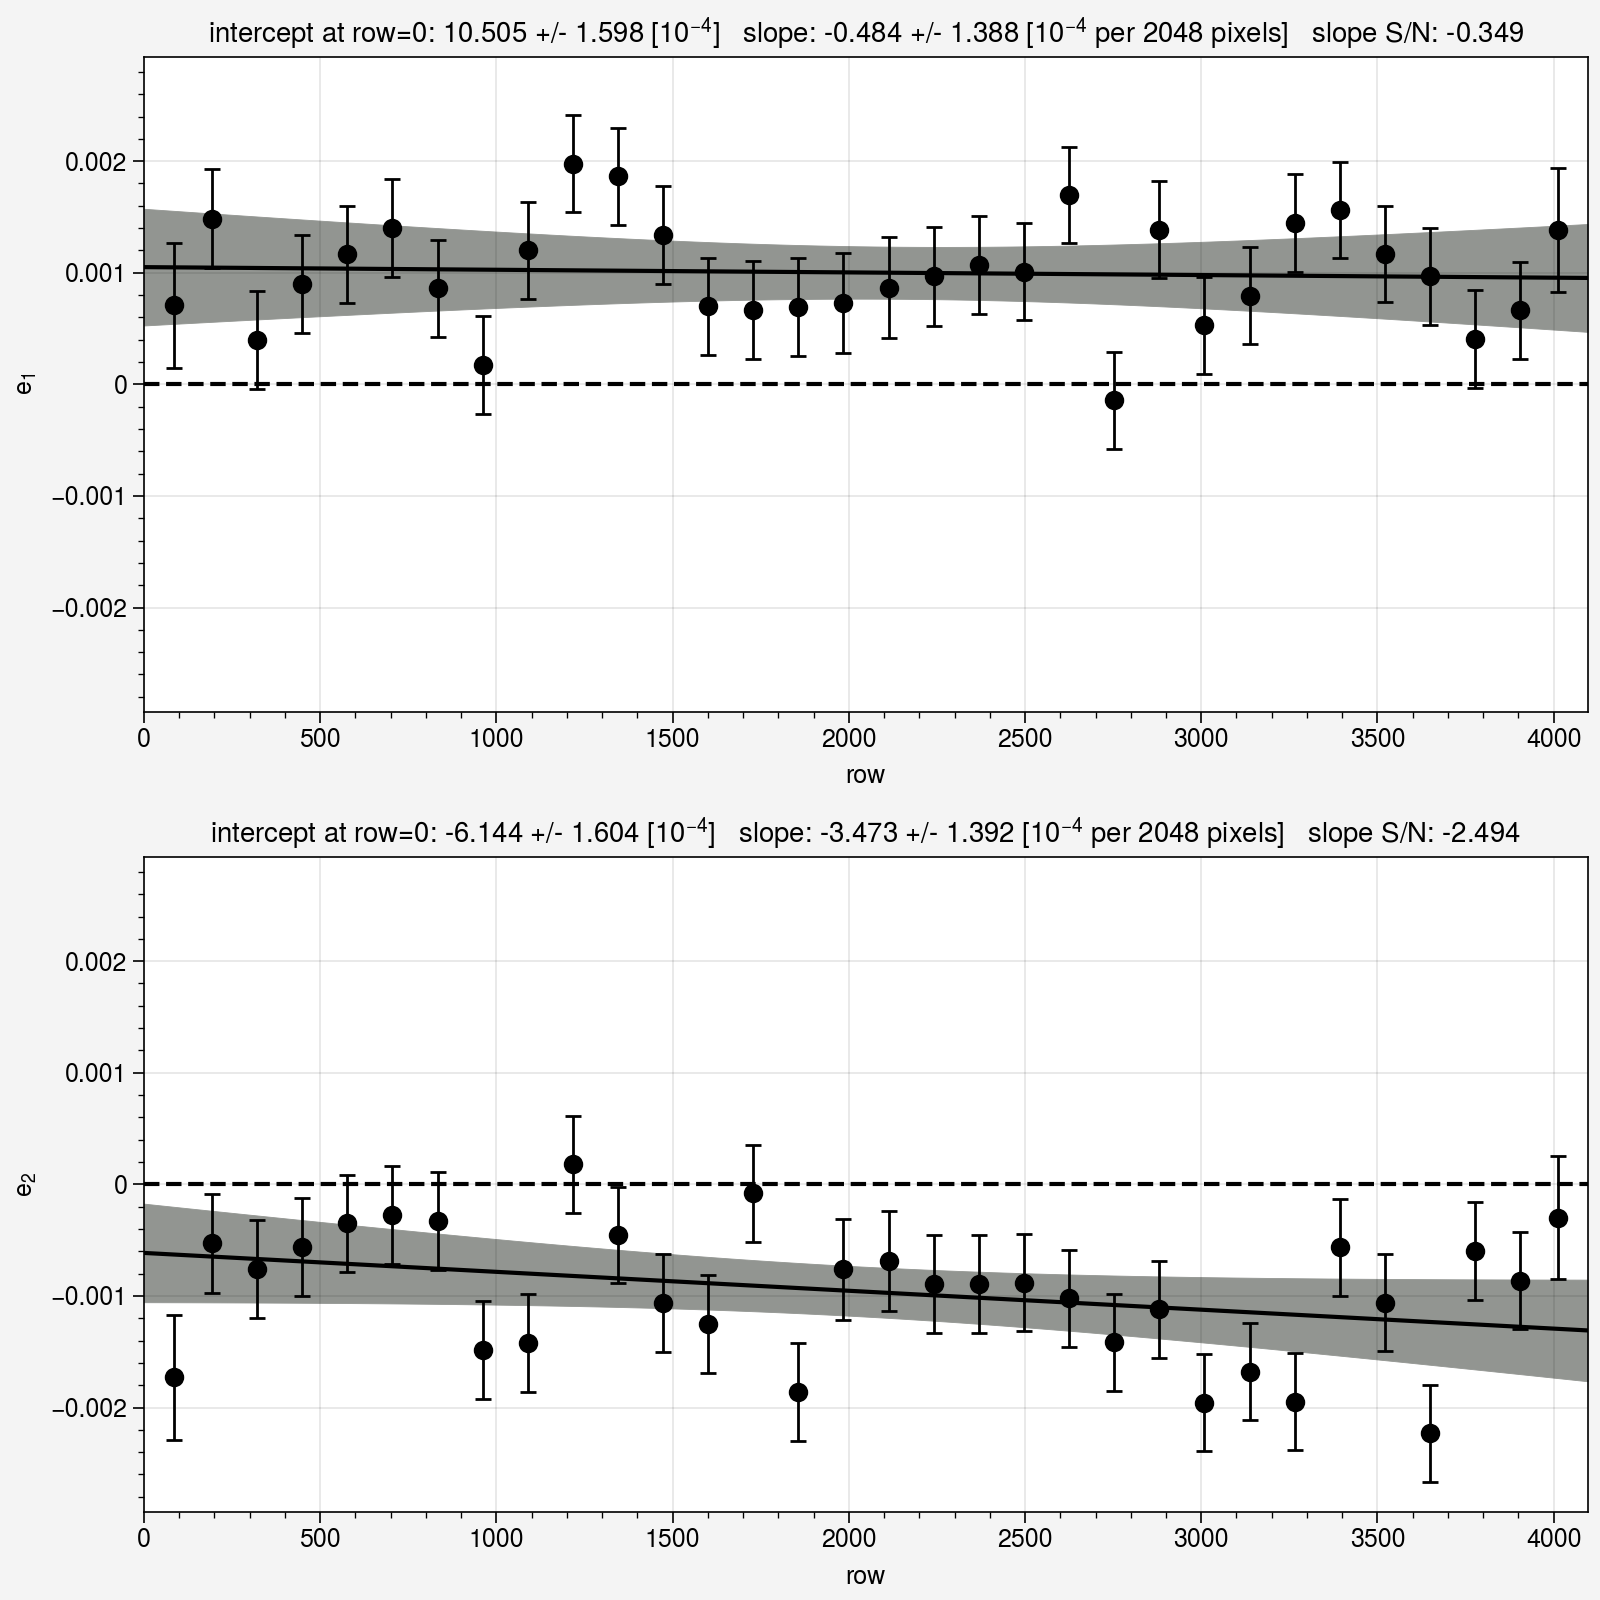

In [4]:
from scipy.optimize import curve_fit

e1s = fitsio.read("cte_data_all_row.fits", ext="e1")
e1s_err = fitsio.read("cte_data_all_row.fits", ext="e1_err")
e2s = fitsio.read("cte_data_all_row.fits", ext="e2")
e2s_err = fitsio.read("cte_data_all_row.fits", ext="e2_err")
rows = fitsio.read("cte_data_all_row.fits", ext="row")


def lin(x, m, c):
    return x/2048*m + c
    

def _fit_and_plot(rows, e, e_err, axs):
    r = curve_fit(lin, rows, e, sigma=e_err, absolute_sigma=True)
    xp = np.linspace(0, 4096, 100)
    yp = lin(xp, *r[0])

    vals = []
    for i in range(200):
        p = np.random.multivariate_normal(r[0], r[1])
        vals.append(lin(xp, *p))
    err = np.std(np.array(vals), axis=0)*3

    axs.plot(xp, yp, color='k')
    axs.fill_between(xp, yp-err, yp+err, color="gray")

    axs.plot(rows, e, "ko", bardata=e1s_err)

    axs.set_xlim(0, 4096)
    axs.axhline(0, color="k", linestyle="dashed")

    p = -4 # int(np.floor(np.log10(np.abs(r[0][0]))))

    axs.set_title(
        "intercept at row=0: %0.3f +/- %0.3f [$10^{-4}$]   "
        "slope: %0.3f +/- %0.3f [$10^{%s}$ per 2048 pixels]   "
        "slope S/N: %0.3f" % (
            r[0][1]/1e-4,
            np.sqrt(np.diagonal(r[1]))[1]/1e-4,
            r[0][0]/10**p,
            np.sqrt(np.diagonal(r[1]))[0]/10**p,
            str(p),
            r[0][0]/np.sqrt(r[1][0, 0])
        ),
    )
    
fig, axs = pplt.subplots(nrows=2, ncols=1, figsize=(8, 8), share=0)

yl = np.max([
    np.abs(e1s+e1s_err), 
    np.abs(e1s-e1s_err),
    np.abs(e2s+e2s_err),
    np.abs(e2s-e2s_err),
])*1.10

_fit_and_plot(rows, e1s, e1s_err, axs[0, 0])
axs[0, 0].set_xlabel("row")
axs[0, 0].set_ylabel("$e_1$")
axs[0, 0].set_ylim(-yl, yl)

_fit_and_plot(rows, e2s, e2s_err, axs[1, 0])
axs[1, 0].set_xlabel("row")
axs[1, 0].set_ylabel("$e_2$")
axs[1, 0].set_ylim(-yl, yl)

## Focal Plane

In [5]:
nccd_per_row = [3, 4, 5, 6, 6, 7,  7,  6,  6,  5,  4,  3]
y_gap_sign =   [5.5, 4.5, 3.5, 2.5, 1.5, 0.5, -0.5, -1.5, -2.5, -3.5, -4.5, -5.5]
gap = 128
ccdrows = []
x_starts = []
y_starts = []
for yind, n in enumerate(nccd_per_row):
    if n % 2 == 1:
        ngen = (n-1)//2
        xgaps = (
            # left of center moves left
            [-gap-i*gap for i in range(ngen)][::-1] 
            # middle the same
            + [0] 
            # right of center moves right
            + [gap + i*gap for i in range(ngen)]
        )
    else:
        ngen = n//2
        xgaps = (
            # left of center moves left
            [-0.5*gap-i*gap for i in range(ngen)][::-1] 
            # right of center moves right
            + [0.5*gap + i*gap for i in range(ngen)]
        )
        
    ccdrows += [n]*n
    off = (7-n)/2 * 4096
    x_starts += [off + i*4096 + xgaps[i] for i in range(n)][::-1]
    y_starts += [(len(nccd_per_row) - 1 - yind)*2048 + gap * y_gap_sign[yind]] * n
x_starts = np.array(x_starts)
y_starts = np.array(y_starts)

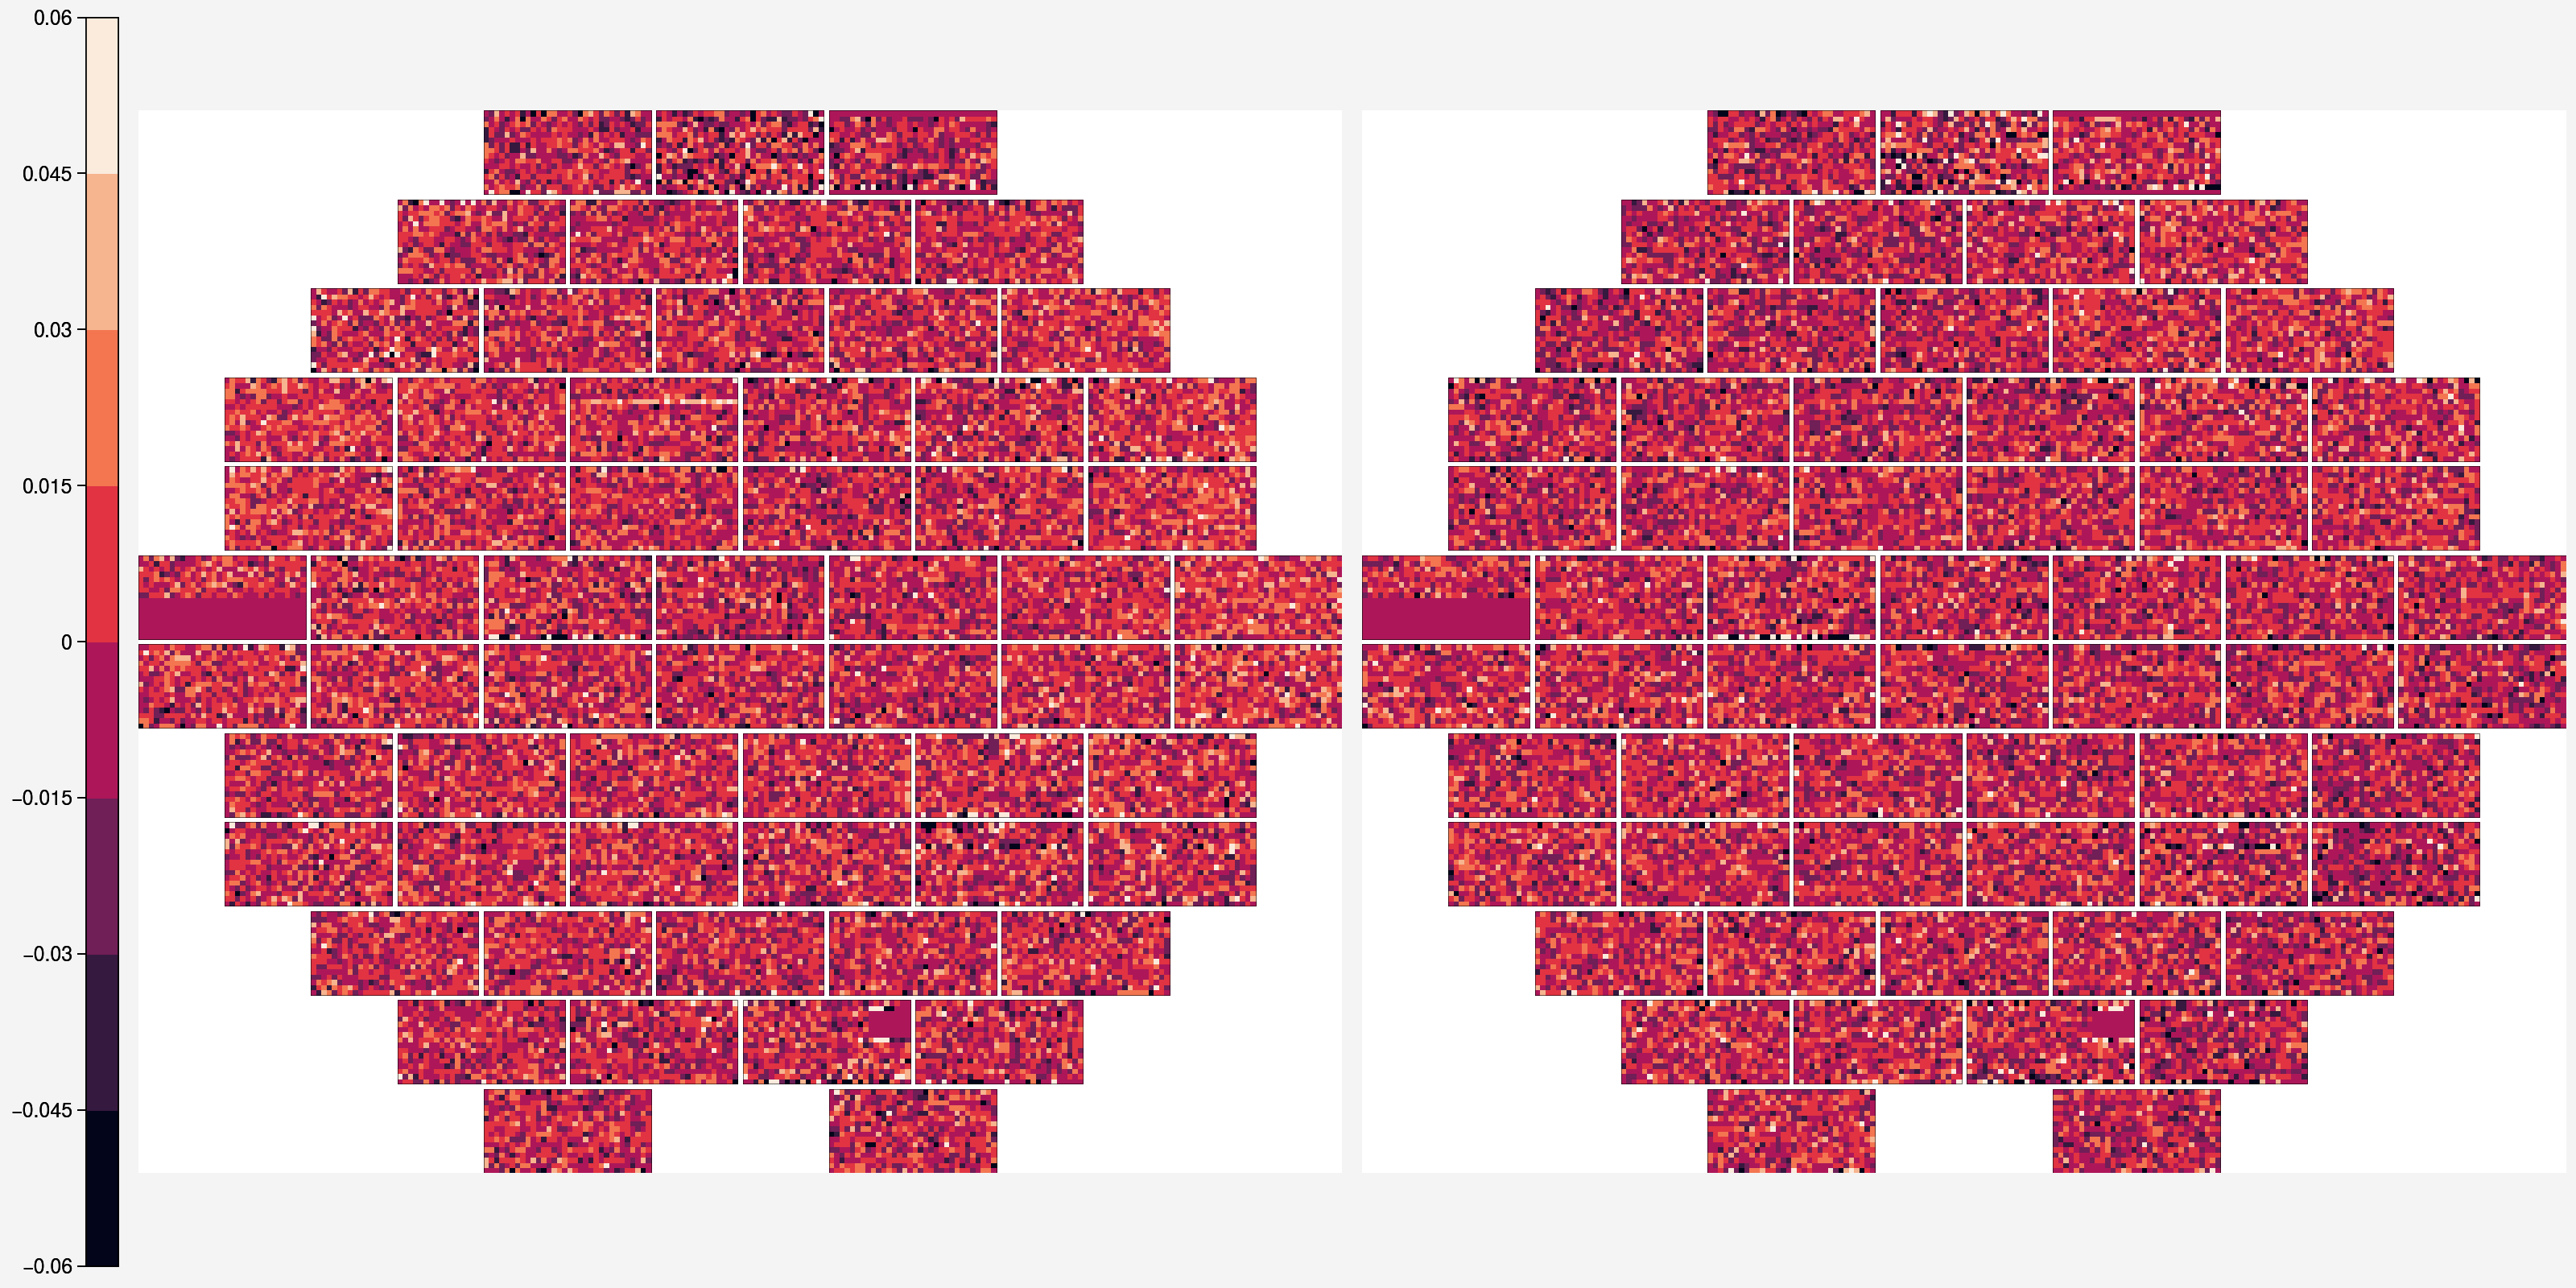

In [6]:
fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(16, 8), share=0)
vmin = None
vmax = None
for i in range(62):
    ccd = i + 1
    try:
        fn = "cte_data_all_ccd%02d.fits" % ccd
        e1 = fitsio.read(fn, ext="e1")
        e1_err = fitsio.read(fn, ext="e1_err")
        e2 = fitsio.read(fn, ext="e2")
        e2_err = fitsio.read(fn, ext="e2_err")
        # print(np.nanmax([np.abs(e1/e1_err), np.abs(e1/e1_err)]), flush=True)
        if vmin is None or vmax is None:
            vmax = np.nanmax([np.abs(e1[1:-1, 1:-1]), np.abs(e2[1:-1, 1:-1])])*0.3
            vmin = -vmax
            if False:
                vmin = -5.5
                vmax = -vmin
        
    except Exception:
        pass
    else:
        x = x_starts[i]
        y = y_starts[i]
        xl, yl = np.meshgrid(
           np.arange(33) * 128 + x,
           np.arange(17) * 128 + y,
        )
        a = axs[0, 0].pcolormesh(
            xl, yl, e1.T[::-1, ::-1],
            vmin=vmin, vmax=vmax, 
            cmap="rocket", 
        )
        axs[0, 0].plot(
            [x, x+4096, x+4096, x, x],
            [y, y, y+2048, y+2048, y],
            color="k", lw=0.2,
        )
        
        axs[0, 1].pcolormesh(
            xl, yl, e2.T[::-1, ::-1],
            vmin=vmin, vmax=vmax, 
            cmap="rocket", 
        )
        axs[0, 1].plot(
            [x, x+4096, x+4096, x, x],
            [y, y, y+2048, y+2048, y],
            color="k", lw=0.2,
        )
axs[0, 0].format(xspineloc='none', yspineloc='none', grid=False)
axs[0, 1].format(xspineloc='none', yspineloc='none', grid=False)
axs[0, 0].set_aspect(1)
axs[0, 1].set_aspect(1)

fig.colorbar(a, loc='l')